# Convert word into templated sentence

Convert goals

In [21]:
import re
from num2words import num2words
def goal_translate(goals):
    goal_trans = ''
    sub_goal = ''
    for goal in goals:
        act = re.findall(r'\w+\b', goal)
        #print(act)
        if len(act)==2:
            sub_goal = '{} the {}'.format(act[0],act[1])
        if len(act)==4:
            sub_goal = 'put {} {} {} {}'.format(num2words(act[3]),act[1], act[0], act[2])
        goal_trans = goal_trans + sub_goal + ', '
    goal_trans = goal_trans.lower()
    goal_trans = goal_trans[:-2] + '.'
    return goal_trans

In [22]:
goals = ['INSIDE (cutleryfork, dishwasher): 3','ON (wineglass, sink): 2','INSIDE (waterglass, dishwasher): 1',
         'CLOSE (dishwasher)','TURNON (dishwasher)']
goal_translate(goals)

'put three cutleryfork inside dishwasher, put two wineglass on sink, put one waterglass inside dishwasher, close the dishwasher, turnon the dishwasher.'

# Get Partial Observations

Enter virtualhome environment

In [24]:
import IPython.display
from virtualhome.demo.utils_demo import *
from sys import platform
import matplotlib.pyplot as plt
from virtualhome.simulation.unity_simulator.comm_unity import UnityCommunication
from virtualhome.simulation.unity_simulator import utils_viz

mode = 'manual'
if mode == 'auto':
    if platform == 'darwin':
        exec_file = '../simulation/macos_exec'
    else:
        exec_file = '../simulation/exec_linux.x86_64'
    comm = UnityCommunication(file_name=exec_file)
else:
    comm = UnityCommunication()

Define the functions to add a character into the environment, get the objects that are visible in the character's view, and obtain the name, state and positions of these objects

{11: {'name': 'livingroom', 'state': [], 'position': [0.0, 0.0, 0.0, -6.02396727, -1.25, 2.18392467]}, 28: {'name': 'tvstand', 'state': [], 'position': [-0.019, 0.0, -2.384, -6.04296727, -1.25, -0.20007532999999977]}, 81: {'name': 'rug', 'state': [], 'position': [1.45780861, 0.0, -2.71302652, -4.56615866, -1.25, -0.52910185]}, 84: {'name': 'pillow', 'state': [], 'position': [-1.672, 0.583, -2.777, -7.69596727, -0.667, -0.59307533]}, 106: {'name': 'tv', 'state': ['OFF'], 'position': [0.07999999, 0.344, -2.38500023, -5.94396728, -0.906, -0.20107556000000004]}, 108: {'name': 'remotecontrol', 'state': ['OFF'], 'position': [-0.0300000086, 0.3445, -2.887, -6.0539672786, -0.9055, -0.7030753299999999]}, 109: {'name': 'kitchen', 'state': [], 'position': [7.5, 0.0, 0.022, 1.47603273, -1.25, 2.20592467]}, 128: {'name': 'door', 'state': ['OPEN'], 'position': [2.45699978, 0.995, -2.03799987, -3.56696749, -0.255, 0.14592479999999997]}, 130: {'name': 'wallshelf', 'state': [], 'position': [5.225, 1.71

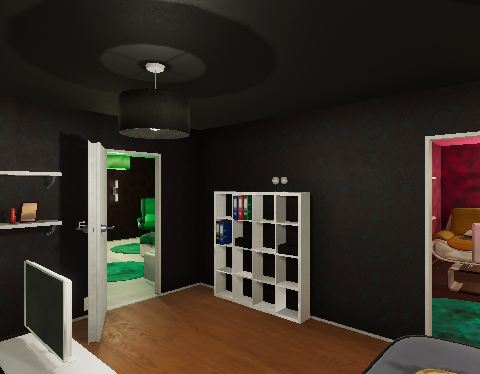

In [99]:
comm.reset(4)

def create_character(character, camera_height, room):
    comm.add_character_camera(position=[0, camera_height, 0], name=character + '_camera')
    comm.add_character(character, initial_room=room)
    _, graph = comm.environment_graph()
    character_index = [node['id'] for node in graph['nodes'] if node['class_name'] == 'character'][-1]
    __, camera_num = comm.camera_count()
    return character_index, camera_num - 1

def get_visible_objects_id(character_index, camera_index):
    _, visible_objects = comm.get_visible_objects(camera_index)
    visible_objects_id_set = set()
    for i in visible_objects:
        if i != str(character_index):
            visible_objects_id_set.add(int(i))
    return visible_objects_id_set

def get_observations(character_index, visible_objects_id_set):
    _, graph = comm.environment_graph()
    character_position = [node for node in graph['nodes'] if node['id'] == character_index][0]['obj_transform']['position']
    observations = {}
    for node in graph['nodes']:
        if node['id'] in visible_objects_id_set:
            observation = {'name': node['class_name'],
                           'state': node['states'],
                           'position': node['obj_transform']['position'] + list(np.array(node['obj_transform']['position']) - np.array(character_position))
                           }
            observations[node['id']] = observation
    return observations

character_id, camera_id = create_character('chars/Female2', 1.6, 'kitchen')
visible_objects_id = get_visible_objects_id(character_id, camera_id)
partial_observation = get_observations(character_id, visible_objects_id)
print(partial_observation)

img_final = display_scene_cameras(comm, [camera_id], nrows=1)
IPython.display.display(img_final)

# Construct the LM framework

Create word embeddings and tokenizer

In [92]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from keras.models import Sequential, Model, Input
from keras.layers import Dense, ReLU, Concatenate, Lambda
import numpy as np

def get_word_embeddings(lm):
    model = GPT2LMHeadModel.from_pretrained(lm)
    word_embeddings = model.transformer.wte.weight
    return word_embeddings

def get_tokenizer(lm):
    tokenizer = GPT2Tokenizer.from_pretrained(lm)
    return tokenizer

gpt2_word_embeddings = get_word_embeddings('gpt2')
gpt2_tokenizer = get_tokenizer('gpt2')

Embed goals

In [101]:
def get_goal_embeddings(word_embeddings, tokenizer, goal):
    goal_token = tokenizer.encode(goal)
    goal_embeddings = word_embeddings[goal_token,:].detach().numpy()
    return goal_embeddings

action_goals = 'put three cutleryfork inside dishwasher, put two wineglass on sink, put one waterglass inside dishwasher, close the dishwasher, turnon the dishwasher.'
gpt2_goal_embeddings = get_goal_embeddings(gpt2_word_embeddings, gpt2_tokenizer, action_goals)

Embed history

In [102]:
def get_history_embeddings(word_embeddings, tokenizer, history):
    history_token = tokenizer.encode(history)
    history_embeddings = word_embeddings[history_token,:].detach().numpy()
    return history_embeddings

action_history = 'I have walked to the kitchen, grabbed the apple'
gpt2_history_embeddings = get_history_embeddings(gpt2_word_embeddings, gpt2_tokenizer, action_history)

Embed observation

In [103]:
def get_name_embeddings(name):
    name_token = gpt2_tokenizer.encode(name)
    name_embeddings = gpt2_word_embeddings[name_token,:].detach().numpy()
    name_embeddings = np.mean(name_embeddings, axis=0)
    return name_embeddings

gpt2_name_embeddings = get_name_embeddings('kitchen oven')

def get_state_model():
    model = Sequential()
    model.add(Dense(32, input_dim=6))
    return model

gpt2_state_model = get_state_model()
gpt2_state_embeddings = gpt2_state_model.predict(np.array([[1, 0, 0, 1, 0, 0]]))

def get_position_model():
    model = Sequential()
    model.add(Dense(64, input_dim=6))
    model.add(ReLU)
    model.add(Dense(64))
    return model

gpt2_position_model = get_state_model()
gpt2_position_embeddings = gpt2_position_model.predict(np.array([[0.4, 0.2, 0.4, 0.1, 0.02, 0.03]]))

def get_object_model():
    name_input = Input(shape=(1, 768))
    state_input = Input(shape=(1, 6))
    position_input = Input(shape=(1, 6))

    name_embeddings = Lambda(lambda x: x)(name_input)

    state_embeddings = Dense(64)(state_input)

    position_embeddings = Dense(64)(position_input)
    position_embeddings = ReLU()(position_embeddings)
    position_embeddings = Dense(64)(position_embeddings)

    merged = Concatenate()([name_embeddings, state_embeddings, position_embeddings])
    merged = Dense(768)(merged)

    model = Model([name_input, state_input, position_input], merged)
    return model

object_model = get_object_model()
object_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 1, 6)]       0           []                               
                                                                                                  
 dense_87 (Dense)               (None, 1, 64)        448         ['input_45[0][0]']               
                                                                                                  
 input_43 (InputLayer)          [(None, 1, 768)]     0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 1, 6)]       0           []                               
                                                                                           